In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
# New imports for HW3:
import requests
from bs4 import BeautifulSoup

# Intro

## IS-Academia

After looking at the webpage and some requests (using Postman), we can derive the following:
* the URL for the search form
* the URL for the querries
* the base parameters used for querries (espacially the `ww_x_GPS` set to -1 to get all the answers)

In [2]:
form_url = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter'
base_url = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html'
params = {'ww_i_reportModel':'133685247', 
          'ww_i_reportModelXsl':'133685270', 
          'ww_x_GPS':'-1'}

In [3]:
page = requests.get(form_url, params)

Now that we get the page, we can use Beautifulsoup to parse it and retrieve all the select fields and their corresponding options:

In [4]:
soup = BeautifulSoup(page.content, 'lxml')
keys = {}
for s in soup.find_all('select'):
    for o in s.find_all('option'):
        if o.text != '': # No need for empty (default values)
            keys.setdefault(s['name'], {}).update({o.text: o['value']})

# A helper method to change a parameter
# name : the parameter
# key : the key in plain text (eg. 'Bachelor semestre 1')
def updateParam(name, key):
    return params.update({name: keys[name][key]})

Now we have the information needed to querry the server.  
__Remark:__ the field for winter/spring semester is purely redondent. (eg. selecting 'Bachelor semester 1' and spring semester produces an empty answer.)

## Task 1

We thought of different methods/assumptions:
1. __Look for min(Bachelor sem. 1) and max(Bachelor sem. 5, Bachelor sem. 6)__  
1.1. + This would count all the time spent in Bachelor for every student  
1.2. - We can't know if students for recent years are finished or not  
2. __Take all semesters and sum them__  
2.1. + We get a fined grained result of the semesters spent by a student in Bachelor  
2.2. - Students who changed section during their Bachelor are counted wrong _(There's one who has only 4 sem.)_  
3. __Take min(Bachelor sem. 1) and min(Bachelor sem. 6)__  
3.1. + This should be more relevent as all results are present  
3.2. - It's only indicating the time taken from BA1 to BA6 ("first attempt")  

__Decision:__ To best compute _"Compute how many months it took each student to go from the first to the sixth semester"_, we decided to:
* Take point 3 (from above).
* This should mean that results are plain years (as uneven sem. are winter sem. and vice-versa)
* All results should be $>=3$

In [5]:
# Preparing the keys for the querries:
updateParam('ww_x_UNITE_ACAD', 'Informatique')
years = keys['ww_x_PERIODE_ACAD']
semesters = ['Bachelor semestre 1', 'Bachelor semestre 6']

# Helper method to get the correct year from encoding YYYY-YYYY
# sem : the semester (eg. Bachelor semestre 1)
# year : the encoded year (eg. 2007-2008)
def getYear(sem, year):
    s = int(sem[-1])
    return int(year.split('-')[(0 if s % 2 == 1 else 1)])

# Requesting all the needed students' information:
students = {}
for year in years.keys():
    for sem in semesters:
        updateParam('ww_x_PERIODE_ACAD', year)
        updateParam('ww_x_PERIODE_PEDAGO', sem)
        r = requests.get(base_url, params).text
        soup = BeautifulSoup(r, 'lxml')
        for row in soup.findAll('tr'):
            if row.contents[0].name != 'th':
                gender = 'M' if row.contents[0].text == 'Monsieur' else 'F'
                sciper = row.contents[10].text
                if not sciper in students:
                    students[sciper] = {'gender':gender}
                if not sem in students[sciper]:
                    students[sciper][sem] = []
                students[sciper][sem].append(getYear(sem, year))

gender,F,M
duration,,
36,26.0,301.0
48,3.0,63.0
60,0.0,4.0


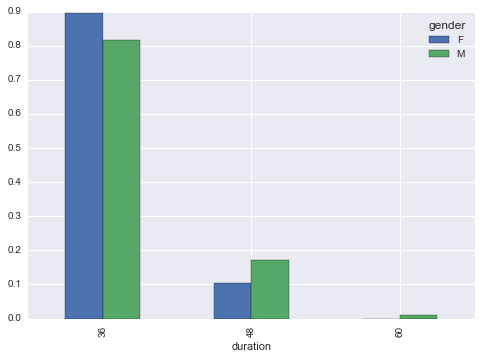

In [6]:
# Filtering the results to keep only the relevant ones:
students_finished = []
for sciper, v in students.items():
    if all (sem in v for sem in ('Bachelor semestre 1', 'Bachelor semestre 6')):
        duration = (min(v['Bachelor semestre 6']) - min(v['Bachelor semestre 1'])) * 12
        gender = v['gender']
        students_finished.append({'gender':gender, 'duration':duration})
        
# Creating a nice representation and plotting the results:
df = pd.DataFrame(students_finished).groupby(['duration', 'gender']).agg(len).unstack().fillna(0)
df.apply(lambda x: x / df.sum(), axis=1).plot.bar()
df


In [7]:
groups = pd.DataFrame(students_finished).groupby(['gender'])
males = groups.get_group('M').drop('gender', axis=1)
females = groups.get_group('F').drop('gender', axis=1)

In [8]:
females.mean()

duration    37.241379
dtype: float64

In [9]:
males.mean()

duration    38.315217
dtype: float64

### Significant 
Let now check the statistical significance.

The distribution of the number of years spent is not normal for at least these two reasons:
* Students can't do it in less than 3 years
* Most of students finished in 3 years

Slide 25 of the [course](https://docs.google.com/presentation/d/1ePWXvwJkUrYBvoAzOqIigFLOh4ZDjhh3x1gkp8znCrg/edit#slide=id.g179faf3a1c_0_95) suggests that _Mann-Whitney_ test is a good test. Indeed,
- Two samples
- Non-normal distribution (previous argument)
- Unpaired samples (as explained by [this](http://www.sjsu.edu/faculty/gerstman/StatPrimer/paired.pdf))

This test is implemented in Scipy.

In [10]:
from scipy import stats

T, p_value = stats.mannwhitneyu(females, males)
p_value

0.1398187300313633